--2025-04-15 06:06:23--  https://raw.githubusercontent.com/opencv/opencv/master/samples/data/box.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50728 (50K) [image/png]
Saving to: ‘box.png’

box.png             100%[===================>]  49.54K  --.-KB/s    in 0.01s   

2025-04-15 06:06:23 (5.03 MB/s) - ‘box.png’ saved [50728/50728]

--2025-04-15 06:06:23--  https://raw.githubusercontent.com/opencv/opencv/master/samples/data/box_in_scene.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 122490 (120K) [image/png]
Saving to: 

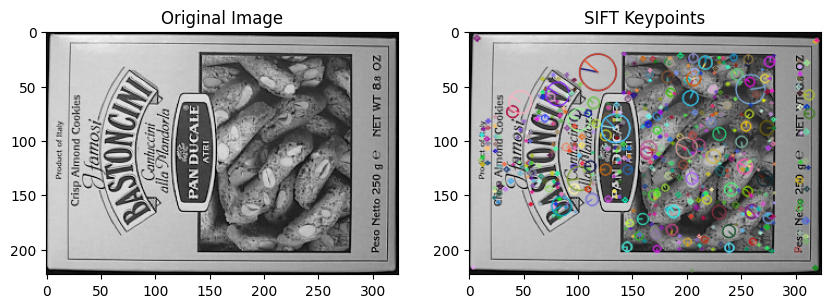

Number of keypoints detected: 604

=== Feature Matching with ORB and BFMatcher ===


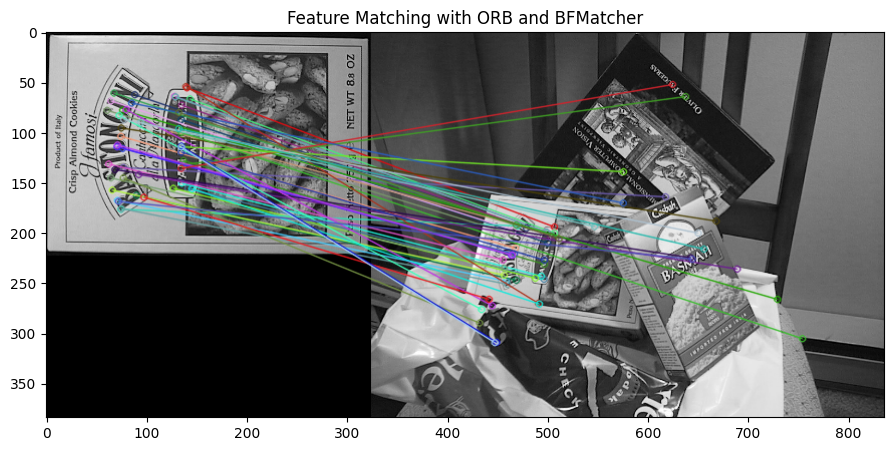

Number of matches found: 148

=== Contour Detection with Watershed ===


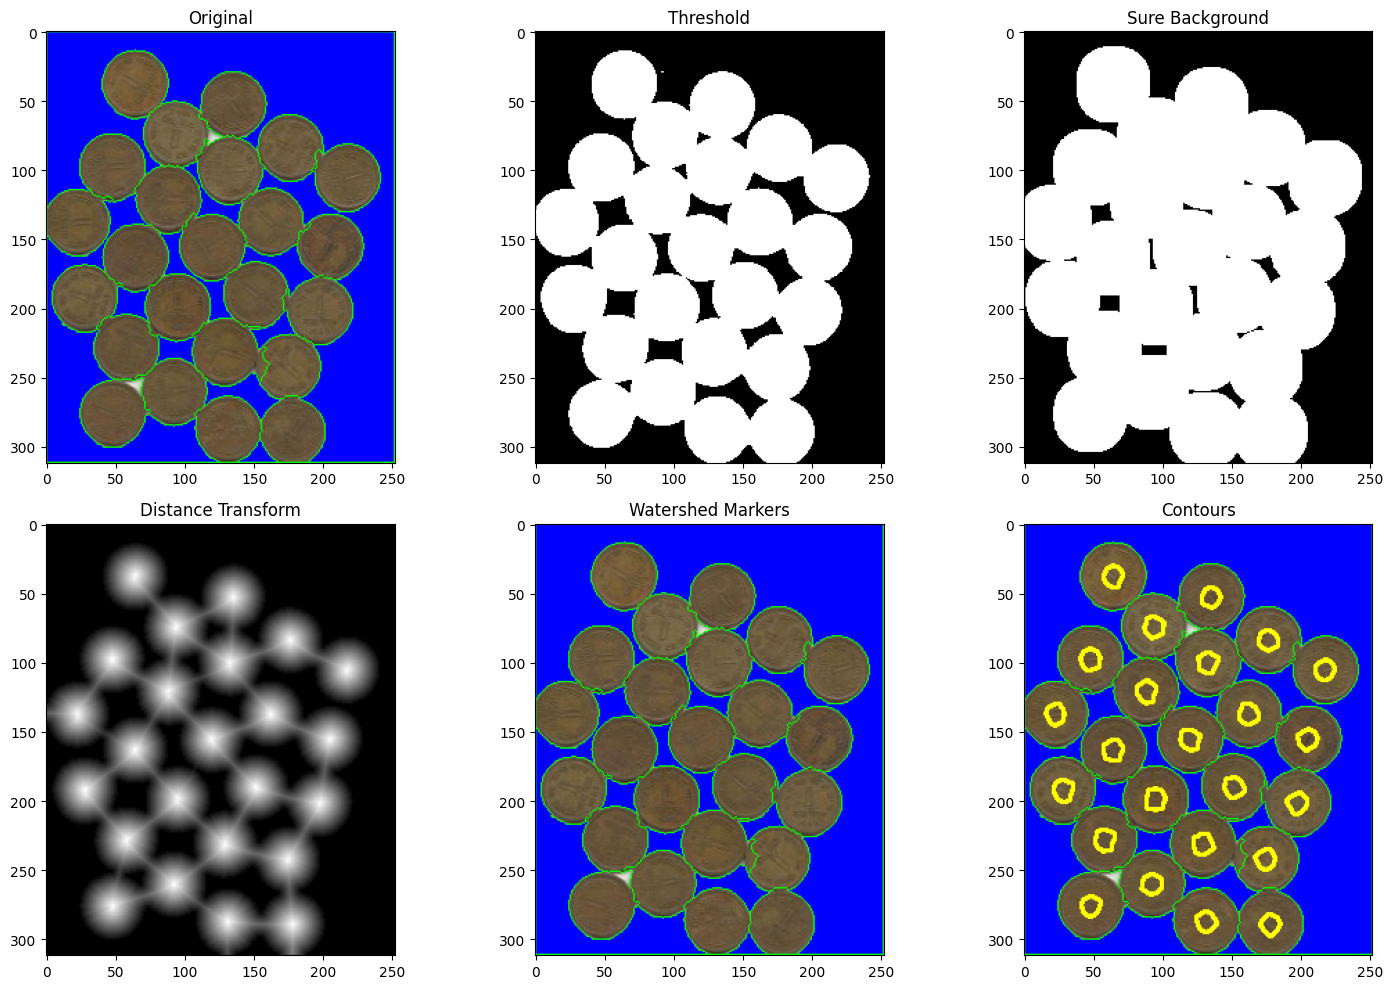

Number of contours detected: 24


In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

# Download sample images
!wget https://raw.githubusercontent.com/opencv/opencv/master/samples/data/box.png -O box.png
!wget https://raw.githubusercontent.com/opencv/opencv/master/samples/data/box_in_scene.png -O box_in_scene.png
!wget https://docs.opencv.org/4.x/coins.jpg -O coins.jpg

# Task 1: Interest Point Detection with SIFT
def sift_detection():
    print("\n=== SIFT Interest Point Detection ===")
    # Read the image
    img = cv2.imread('box.png', cv2.IMREAD_GRAYSCALE)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(img, None)

    # Draw keypoints
    img_kp = cv2.drawKeypoints(img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Display results
    plt.figure(figsize=(10, 5))
    plt.subplot(121), plt.imshow(img, cmap='gray'), plt.title('Original Image')
    plt.subplot(122), plt.imshow(img_kp), plt.title('SIFT Keypoints')
    plt.show()

    print(f"Number of keypoints detected: {len(keypoints)}")

# Task 2:+
def feature_matching():
    print("\n=== Feature Matching with ORB and BFMatcher ===")
    # Read images
    img1 = cv2.imread('box.png', cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread('box_in_scene.png', cv2.IMREAD_GRAYSCALE)

    # Initialize ORB detector
    orb = cv2.ORB_create()

    # Find keypoints and descriptors
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    # Create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors
    matches = bf.match(des1, des2)

    # Sort them in ascending order of distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Draw first 50 matches
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Display results
    plt.figure(figsize=(15, 5))
    plt.imshow(img_matches)
    plt.title('Feature Matching with ORB and BFMatcher')
    plt.show()

    print(f"Number of matches found: {len(matches)}")

# Task 3: Contour Detection with Custom Seeds (Watershed)
def contour_detection():
    print("\n=== Contour Detection with Watershed ===")
    # Read the image
    img = cv2.imread('coins.jpg')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply thresholding
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Noise removal
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # Sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1

    # Mark the region of unknown with zero
    markers[unknown == 255] = 0

    # Apply watershed
    markers = cv2.watershed(img, markers)

    # Color boundaries in green and mark background with red
    img[markers == -1] = [0, 255, 0]
    img[markers == 1] = [255, 0, 0]  # background

    # Find contours
    contours, hierarchy = cv2.findContours(sure_fg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours
    img_contours = img.copy()
    cv2.drawContours(img_contours, contours, -1, (0, 255, 255), 2)

    # Display results
    plt.figure(figsize=(15, 10))

    plt.subplot(231), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Original')
    plt.subplot(232), plt.imshow(thresh, cmap='gray'), plt.title('Threshold')
    plt.subplot(233), plt.imshow(sure_bg, cmap='gray'), plt.title('Sure Background')
    plt.subplot(234), plt.imshow(dist_transform, cmap='gray'), plt.title('Distance Transform')
    plt.subplot(235), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Watershed Markers')
    plt.subplot(236), plt.imshow(cv2.cvtColor(img_contours, cv2.COLOR_BGR2RGB)), plt.title('Contours')

    plt.tight_layout()
    plt.show()

    print(f"Number of contours detected: {len(contours)}")

# Run all tasks
def main():
    sift_detection()
    feature_matching()
    contour_detection()

if __name__ == "__main__":
    main()

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.utils.data as data
import numpy as np
import matplotlib.pyplot as plt
import time
from torchsummary import summary

# Step 1: Installation of necessary libraries
!pip install torch torchvision deeplake
import deeplake

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 2: Load the dataset
def load_cifar100():
    # Define transformations
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ])

    # Load CIFAR-100 dataset
    train_dataset = torchvision.datasets.CIFAR100(
        root='./data', train=True, download=True, transform=transform_train)
    test_dataset = torchvision.datasets.CIFAR100(
        root='./data', train=False, download=True, transform=transform_test)

    # Create data loaders
    train_loader = data.DataLoader(
        train_dataset, batch_size=128, shuffle=True, num_workers=2)
    test_loader = data.DataLoader(
        test_dataset, batch_size=100, shuffle=False, num_workers=2)

    return train_loader, test_loader

train_loader, test_loader = load_cifar100()

# Step 3: Load the pretrained Model
def get_model(model_name):
    if model_name == 'resnet18':
        model = torchvision.models.resnet18(pretrained=False)
        # Adjust for CIFAR-100 (32x32 images)
        model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        model.maxpool = nn.Identity()
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 100)  # CIFAR-100 has 100 classes
    elif model_name == 'resnet34':
        model = torchvision.models.resnet34(pretrained=False)
        # Adjust for CIFAR-100 (32x32 images)
        model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        model.maxpool = nn.Identity()
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 100)  # CIFAR-100 has 100 classes
    else:
        raise ValueError("Model not supported")

    return model.to(device)

# Step 4: Train the Models
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_acc = 0.0
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(test_loader.dataset)
        epoch_acc = running_corrects.double() / len(test_loader.dataset)
        val_loss_history.append(epoch_loss)
        val_acc_history.append(epoch_acc)

        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if scheduler is not None:
            scheduler.step()

        # Deep copy the model if it's the best so far
        if epoch_acc > best_acc:
            best_acc = epoch_acc

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    return {
        'model': model,
        'train_loss_history': train_loss_history,
        'val_loss_history': val_loss_history,
        'train_acc_history': train_acc_history,
        'val_acc_history': val_acc_history,
        'training_time': time_elapsed
    }

# Step 5: Evaluate the Performances
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    inference_time = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            start_time = time.time()
            outputs = model(images)
            inference_time += time.time() - start_time

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_inference_time = inference_time / len(test_loader)

    print(f'Accuracy of the network on the 10000 test images: {accuracy:.2f}%')
    print(f'Average inference time per batch: {avg_inference_time:.4f} seconds')

    return accuracy, avg_inference_time

# Step 6: Compare the results
def compare_models():
    # Hyperparameters
    num_epochs = 25
    learning_rate = 0.1
    momentum = 0.9
    weight_decay = 5e-4

    # Models to compare
    model_names = ['resnet18', 'resnet34']
    results = {}

    for model_name in model_names:
        print(f"\n=== Training {model_name} ===")

        # Initialize model
        model = get_model(model_name)
        print(f"{model_name} architecture:")
        summary(model, (3, 32, 32))

        # Loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                            momentum=momentum, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

        # Train model
        model_result = train_model(model, criterion, optimizer, scheduler, num_epochs)

        # Evaluate model
        accuracy, inference_time = evaluate_model(model_result['model'], test_loader)

        # Store results
        results[model_name] = {
            'train_loss': model_result['train_loss_history'],
            'val_loss': model_result['val_loss_history'],
            'train_acc': model_result['train_acc_history'],
            'val_acc': model_result['val_acc_history'],
            'training_time': model_result['training_time'],
            'test_accuracy': accuracy,
            'inference_time': inference_time
        }

    return results

# Run the comparison
results = compare_models()

# Plot results
def plot_results(results):
    plt.figure(figsize=(15, 10))

    # Plot training and validation accuracy
    plt.subplot(2, 2, 1)
    for model_name in results:
        plt.plot([x.cpu().numpy() for x in results[model_name]['train_acc']], label=f'{model_name} Train')
        plt.plot([x.cpu().numpy() for x in results[model_name]['val_acc']], '--', label=f'{model_name} Val')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(2, 2, 2)
    for model_name in results:
        plt.plot(results[model_name]['train_loss'], label=f'{model_name} Train')
        plt.plot(results[model_name]['val_loss'], '--', label=f'{model_name} Val')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training time and test accuracy
    plt.subplot(2, 2, 3)
    model_names = list(results.keys())
    training_times = [results[name]['training_time'] for name in model_names]
    test_accuracies = [results[name]['test_accuracy'] for name in model_names]

    plt.bar(model_names, training_times, color='blue')
    plt.title('Training Time')
    plt.ylabel('Seconds')

    plt.subplot(2, 2, 4)
    plt.bar(model_names, test_accuracies, color='green')
    plt.title('Test Accuracy')
    plt.ylabel('Accuracy (%)')

    plt.tight_layout()
    plt.show()

plot_results(results)

# Print final comparison
print("\n=== Final Comparison ===")
for model_name in results:
    print(f"\nModel: {model_name}")
    print(f"Training Time: {results[model_name]['training_time']:.2f} seconds")
    print(f"Test Accuracy: {results[model_name]['test_accuracy']:.2f}%")
    print(f"Inference Time: {results[model_name]['inference_time']:.4f} seconds per batch")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 68.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

100%|██████████| 169M/169M [00:03<00:00, 42.8MB/s]



=== Training resnet18 ===
resnet18 architecture:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
          Identity-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,